## read

In [1]:
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 90

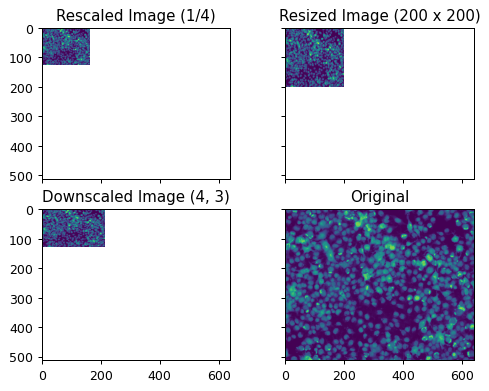

In [2]:
img = io.imread("images/test_image.jpg", as_gray=True)

rescaled_img = rescale(img, 0.25, anti_aliasing=True)
resized_img = resize(img, (200, 200))
downscaled_img = downscale_local_mean(img, (4, 3))

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
axes = axes.ravel()
axes[0].imshow(rescaled_img)
axes[0].set_title("Rescaled Image (1/4)")
axes[1].imshow(resized_img)
axes[1].set_title("Resized Image (200 x 200)")
axes[2].imshow(downscaled_img)
axes[2].set_title("Downscaled Image (4, 3)")
axes[3].imshow(img)
axes[3].set_title("Original")
plt.show()

## filter

In [3]:
from skimage import io
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage.feature import canny

import matplotlib.pyplot as plt

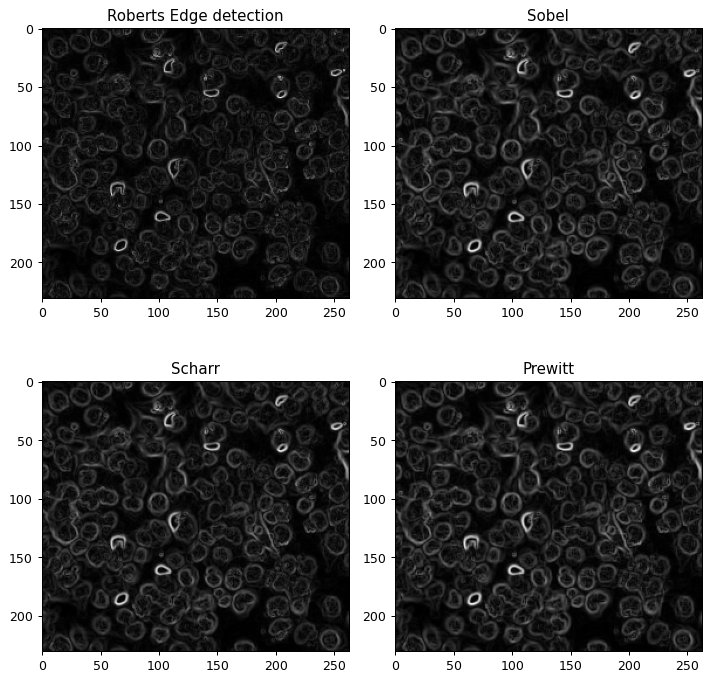

In [4]:
img = io.imread("images/test_image_cropped.jpg", as_gray=True)

edge_robert = roberts(img)
edge_sobel = sobel(img)
edge_scharr = scharr(img)
edge_prewitt = prewitt(img)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()
axes[0].imshow(edge_robert, cmap='gray')
axes[1].imshow(edge_sobel, cmap='gray')
axes[2].imshow(edge_scharr, cmap='gray')
axes[3].imshow(edge_prewitt, cmap='gray')
axes[0].set_title('Roberts Edge detection')
axes[1].set_title('Sobel')
axes[2].set_title('Scharr')
axes[3].set_title('Prewitt')
plt.tight_layout()
plt.show()

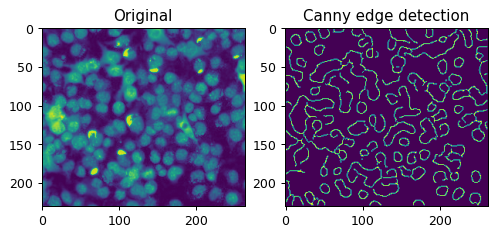

In [5]:
edge_canny = canny(img, sigma=3)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(img)
axes[0].set_title('Original')
axes[1].imshow(edge_canny)
axes[1].set_title('Canny edge detection')
plt.show()

## Deconvolution

In [6]:
from skimage import io
from skimage import restoration

import numpy as np
import matplotlib.pyplot as plt

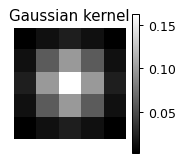

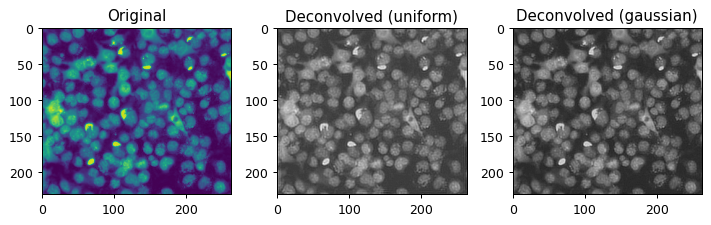

In [7]:
def gkernel(kernel_size=3, sigma=1):
    dd = np.linspace(-(kernel_size-1)/2., (kernel_size-1)/2, kernel_size)
    xx, yy = np.meshgrid(dd, dd)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma))
    return kernel / np.sum(kernel)
plt.figure(figsize=(2, 2))
plt.imshow(gkernel(5, 1), cmap='gray')
plt.colorbar()
plt.title('Gaussian kernel')
plt.axis('off')
plt.show()

img = io.imread("images/test_image_cropped.jpg", as_gray=True)

psf_uniform = np.ones((3, 3)) / 9 # point spread function, why we think image blurred.
psf_gaussian = gkernel(3, 1)
deconvolved_uniform, _ = restoration.unsupervised_wiener(img, psf_uniform)
deconvolved_gaussian, _ = restoration.unsupervised_wiener(img, psf_gaussian)

fig, axes = plt.subplots(1, 3, figsize=(8, 4))
axes[0].imshow(img)
axes[0].set_title('Original')
axes[1].imshow(deconvolved_uniform, cmap='gray')
axes[1].set_title('Deconvolved (uniform)')
axes[2].imshow(deconvolved_gaussian, cmap='gray')
axes[2].set_title('Deconvolved (gaussian)')
plt.tight_layout()
plt.show()

## Example
- scratch assay analysis

In [8]:
import glob

from skimage import io
from skimage.filters.rank import entropy
from skimage.filters import try_all_threshold
from skimage.filters import threshold_otsu
from skimage.morphology import disk

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

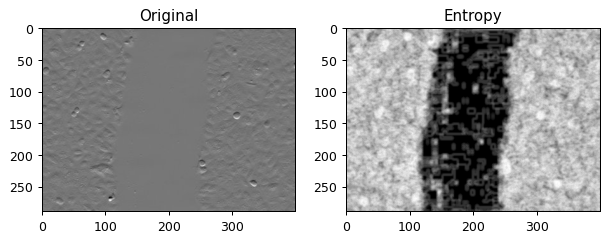

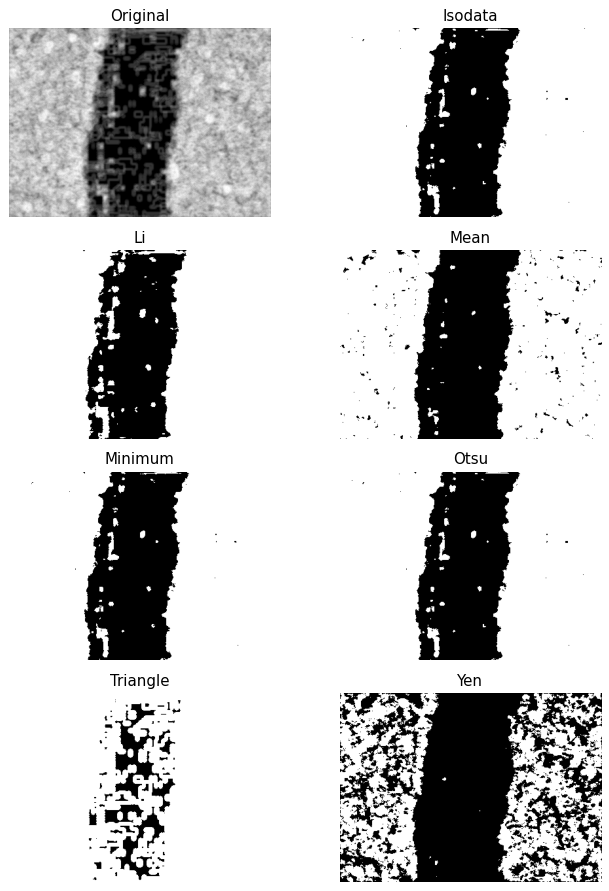

In [9]:
img = io.imread("images/scratch.jpg")
entr_img = entropy(img, disk(3))

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original')
axes[1].imshow(entr_img, cmap='gray')
axes[1].set_title('Entropy')

fig, axes = try_all_threshold(entr_img, figsize=(8, 10), verbose=False)
plt.show()

The percent of bright pixels: 28.92%


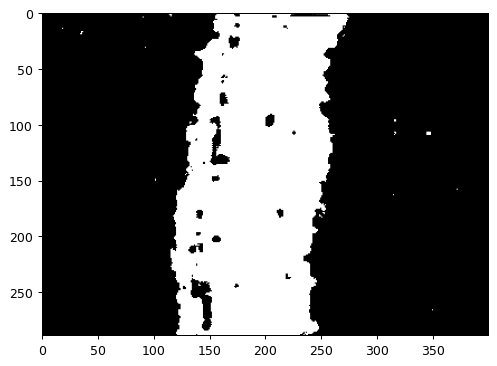

In [10]:
thresh = threshold_otsu(entr_img)
binary = entr_img <= thresh
plt.imshow(binary, cmap='gray')
print(f"The percent of bright pixels: "
      f"{np.sum(binary==1) / np.prod(binary.shape) * 100:.2f}%")

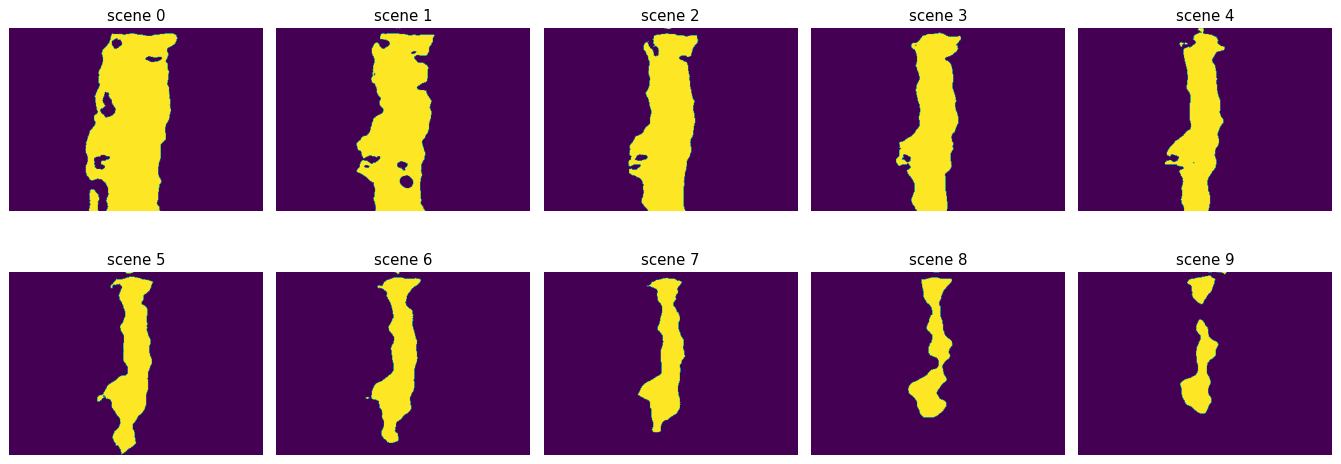

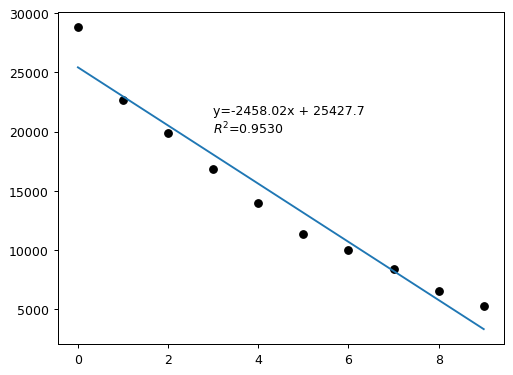

In [11]:
time_lst = []
area_lst = []
path = "images/scratch_assay/*.jpg"
image_paths = sorted(glob.glob(path))

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()
for t, file in enumerate(image_paths):
    img = io.imread(file)
    entropy_img = entropy(img, disk(10))
    thresh = threshold_otsu(entr_img)
    binary = entropy_img <= thresh
    axes[t].imshow(binary)
    axes[t].set_title(f"scene {t}")
    axes[t].axis('off')
    scratch_area = np.sum(binary)

    time_lst.append(t)
    area_lst.append(scratch_area)
plt.tight_layout()
plt.show()

lin_reg = LinearRegression()

X = np.array(time_lst).reshape(-1, 1)
y = np.array(area_lst)

lin_reg.fit(X, y)
y_pred = lin_reg.predict(X)
r2 = r2_score(y, y_pred)

plt.plot(time_lst, y, 'ko')
plt.plot(time_lst, y_pred)
plt.text(time_lst[3], y_pred[3]*1.1,
         f'y={lin_reg.coef_[0]:.6g}x + {lin_reg.intercept_:.6g}\n'
         f'$R^2$={r2:.4f}')
plt.show()

## Denoising

In [12]:
from skimage import io
from skimage.filters import gaussian
from skimage.restoration import denoise_nl_means, estimate_sigma
from scipy import ndimage as nd

import numpy as np
import matplotlib.pyplot as plt

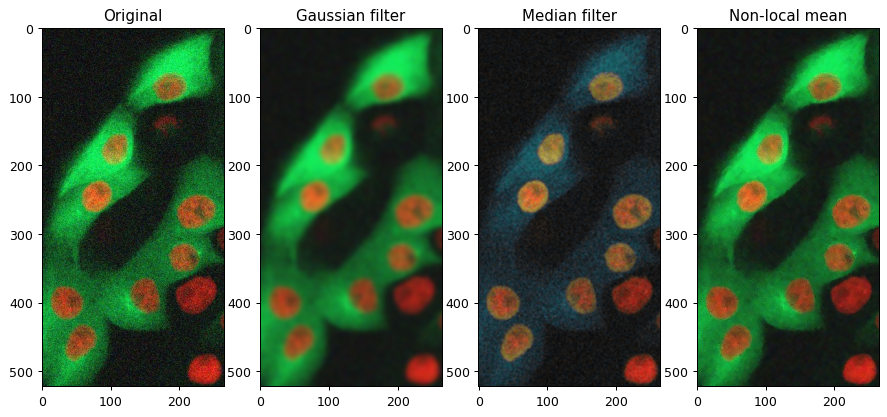

In [13]:
img = io.imread("images/denoising/noisy_img.jpg")
gaussian_img = gaussian(img, sigma=3, channel_axis=-1)
median_img = nd.median_filter(img, size=3)

sigma_est = np.mean(estimate_sigma(img/255, channel_axis=-1))
nlm = denoise_nl_means(img/255,
                                   h=1.15*sigma_est,
                                   fast_mode=False,
                                   patch_size=5,
                                   patch_distance=3,
                                   channel_axis=-1)

fig, axes = plt.subplots(1, 4, figsize=(12, 6))
axes[0].imshow(img)
axes[0].set_title("Original")
axes[1].imshow(gaussian_img)
axes[1].set_title("Gaussian filter")
axes[2].imshow(median_img, cmap='gray')
axes[2].set_title("Median filter")
axes[3].imshow(nlm, cmap='gray')
axes[3].set_title("Non-local mean")
plt.show()

## Histogram based image segmantation
- need preprocessing to seperate regions

In [14]:
from skimage import io
from skimage.restoration import denoise_nl_means, estimate_sigma
from scipy import ndimage as nd

import numpy as np
import matplotlib.pyplot as plt

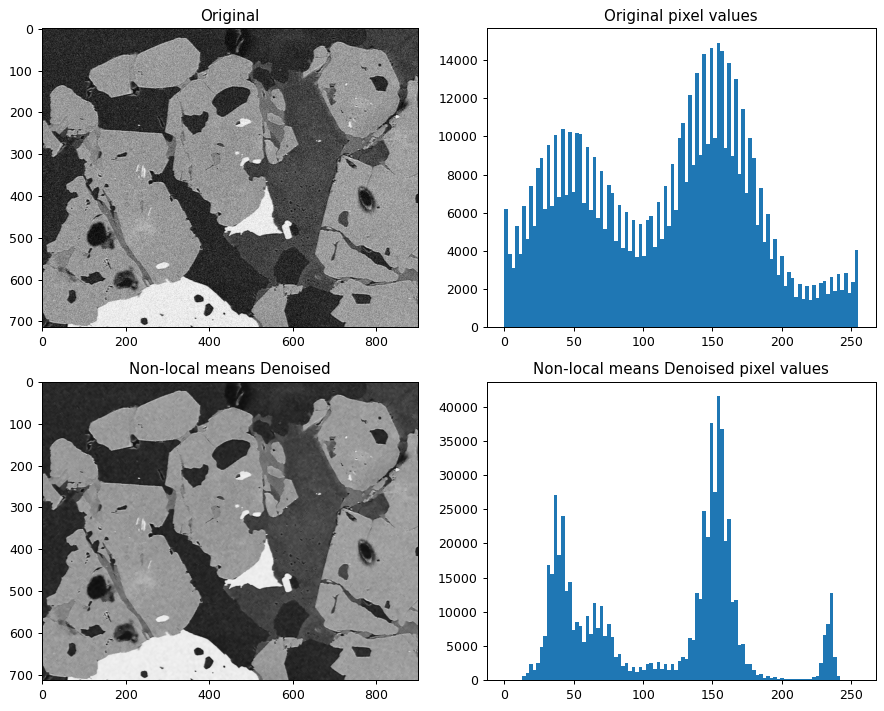

In [15]:
img = io.imread("images/BSE_Google_noisy.jpg").astype(float)
img /= 255.

sigma_est = np.mean(estimate_sigma(img))
denoise = denoise_nl_means(img,
                           h=1.15*sigma_est,
                           fast_mode=False,
                           patch_size=5,
                           patch_distance=3)

img = (img*255).astype(np.uint8)
denoise = (denoise*255).astype(np.uint8)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()
axes[0].imshow(img, cmap='gray')
axes[0].set_title("Original")
axes[1].hist(img.flatten(), bins=100, range=(0, 255))
axes[1].set_title("Original pixel values")

axes[2].imshow(denoise, cmap='gray')
axes[2].set_title("Non-local means Denoised")
axes[3].hist(denoise.flatten(), bins=100, range=(0, 255))
axes[3].set_title("Non-local means Denoised pixel values")
plt.tight_layout()
plt.show()

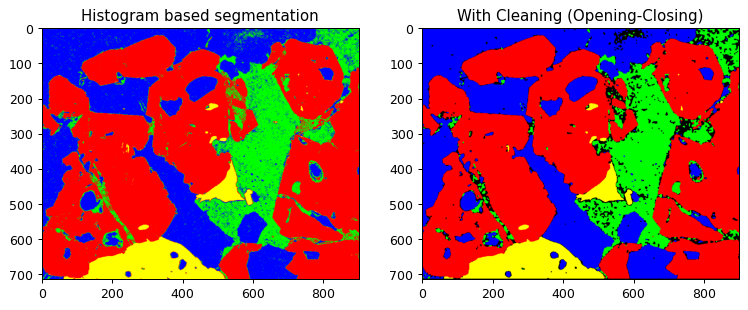

In [16]:
seg1 = (denoise <= 55)
seg2 = (denoise > 55) & (denoise <= 110)
seg3 = (denoise > 110) & (denoise <= 210)
seg4 = denoise > 210
segs = [seg1, seg2, seg3, seg4]

colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0), (1, 1, 0)]
all_segments = np.zeros((denoise.shape[0], denoise.shape[1], 3))
for seg, color in zip(segs, colors):
    all_segments[seg] = color

seg_cleaned = []
all_segments_cleaned = np.zeros((denoise.shape[0], denoise.shape[1], 3))
for seg, color in zip(segs, colors):
    seg_opened = nd.binary_opening(seg, np.ones((3, 3)))
    seg_closed = nd.binary_closing(seg_opened, np.ones((3, 3)))
    all_segments_cleaned[seg_closed] = color


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(all_segments)
axes[0].set_title("Histogram based segmentation")
axes[1].imshow(all_segments_cleaned)
axes[1].set_title("With Cleaning (Opening-Closing)")
plt.show()

### Random walker

In [17]:
from skimage import io
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import exposure
from skimage.segmentation import random_walker

import numpy as np
import matplotlib.pyplot as plt

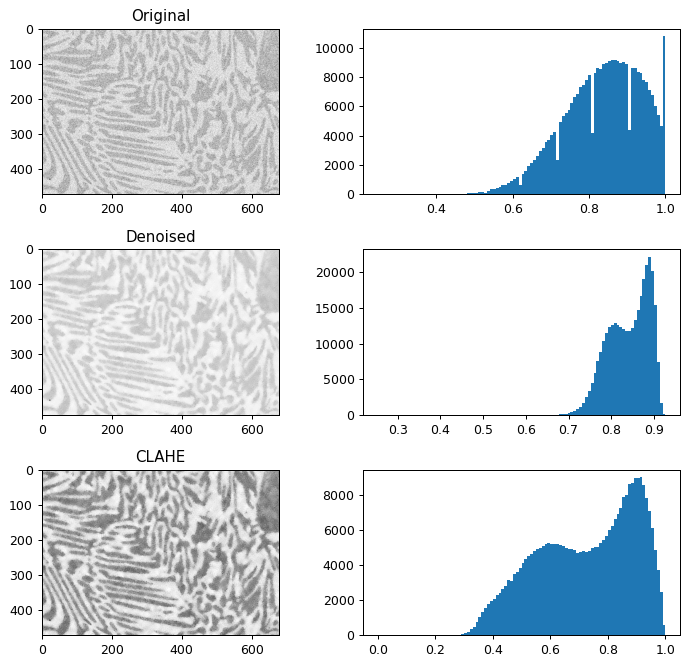

In [18]:
img = io.imread("images/Alloy_noisy.jpg") / 255.

sigma_est = np.mean(estimate_sigma(img))
denoise_img = denoise_nl_means(img,
                               h=1.15*sigma_est,
                               fast_mode=False,
                               patch_size=5,
                               patch_distance=6)

eq_img = exposure.equalize_adapthist(denoise_img)

fig, axes = plt.subplots(3, 2, figsize=(8, 7.5))
axes = axes.ravel()
axes[0].imshow(img, cmap='gray')
axes[0].set_title("Original")
axes[1].hist(img.flatten(), bins=100)
axes[2].imshow(denoise_img, cmap='gray')
axes[2].set_title("Denoised")
axes[3].hist(denoise_img.flatten(), bins=100)
axes[4].imshow(eq_img, cmap='gray')
axes[4].set_title("CLAHE")
axes[5].hist(eq_img.flatten(), bins=100)
plt.tight_layout()
plt.show()

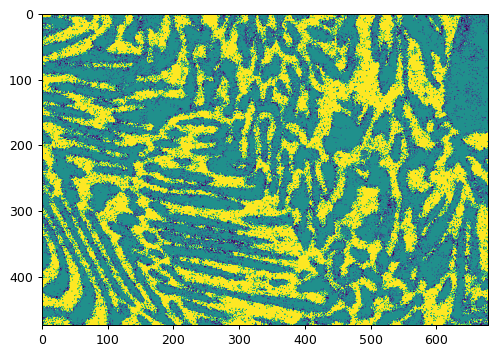

In [19]:
markers = np.zeros(img.shape, dtype=np.uint8)
markers[(eq_img < 0.7) & (eq_img > 0.3)] = 1
markers[(eq_img > 0.8) & (eq_img < 0.99)] = 2

labels = random_walker(eq_img, markers, beta=10, mode='bf')
plt.imshow(markers)
plt.show()